In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from os.path import join
import sys
import json
import geopandas as gpd

In [2]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

In [3]:
# add the 'src' directory as one where we can import modules
src_dir = join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [79]:
%aimport Data.make_data
from Data.make_data import states_in_nerc
%aimport Analysis.index
from Analysis.index import facility_emission_gen, group_facility_data
%aimport Analysis.index
from Analysis.index import facility_co2, adjust_epa_emissions, group_fuel_cats
from Analysis.index import reduce_emission_factors, add_datetime
%aimport util.utils
from util.utils import rename_cols, add_facility_location

## Extra NERC emissions and generation

### Load extra NERC generation and fuel consumption

In [7]:
cwd = os.getcwd()
path = join(cwd, '..', 'Data storage', 'NERC extra gen fuels.csv')
extra_nerc = pd.read_csv(path, index_col=[0, 1, 2, 3])

In [8]:
extra_nerc.head()

generation (mwh)  total fuel (mmbtu)  elec fuel (mmbtu)
year nerc month type                                                         
2016 WECC 1     COW       3.758774e+05        6.325535e+06       4.298811e+06
                GEO       5.326896e+05                 NaN                NaN
                HYC       2.137328e+06                 NaN                NaN
                NG        2.231104e+06        2.732402e+07       1.755353e+07
                OOG      -3.632221e+04                 NaN                NaN

### Load emission factors

In [12]:
path = join(cwd, '..', 'Data storage', 'Final emission factors.csv')
ef = pd.read_csv(path, index_col=0)

In [13]:
ef.head()

,Fuel,Fossil Factor,Notes,Link,Total Factor
EIA Fuel Code,,,,,
BIT,Bituminous Coal,93.30,NaN,https://www.eia.gov/electricity/annual/html/ep...,93.30
DFO,Distillate Fuel Oil,73.16,NaN,https://www.eia.gov/electricity/annual/html/ep...,73.16
GEO,Geothermal,7.71,NaN,https://www.eia.gov/electricity/annual/html/ep...,7.71
JF,Jet Fuel,70.90,NaN,https://www.eia.gov/electricity/annual/html/ep...,70.90
KER,Kerosene,72.30,NaN,https://www.eia.gov/electricity/annual/html/ep...,72.30


In [19]:
ef_type = reduce_emission_factors(ef)

In [22]:
ef_type = pd.Series(ef_type, name='type')
ef_type

COW     95.250
NG      53.070
OOG     59.000
PC     102.100
PEL     75.975
Name: type, dtype: float64

### Calculate CO₂ emissions

In [25]:
extra_nerc.loc[:, 'total co2 (kg)'] = (extra_nerc
                                       .loc[:, 'total fuel (mmbtu)']
                                       .multiply(ef_type, 'type'))
extra_nerc.loc[:, 'elec co2 (kg)'] = (extra_nerc
                                       .loc[:, 'elec fuel (mmbtu)']
                                       .multiply(ef_type, 'type'))

In [26]:
extra_nerc.head()

generation (mwh)  total fuel (mmbtu)  elec fuel (mmbtu)  \
year nerc month type                                                            
2016 WECC 1     COW       3.758774e+05        6.325535e+06       4.298811e+06   
                GEO       5.326896e+05                 NaN                NaN   
                HYC       2.137328e+06                 NaN                NaN   
                NG        2.231104e+06        2.732402e+07       1.755353e+07   
                OOG      -3.632221e+04                 NaN                NaN   

                      total co2 (kg)  elec co2 (kg)  
year nerc month type                                 
2016 WECC 1     COW     6.025072e+08   4.094617e+08  
                GEO              NaN            NaN  
                HYC              NaN            NaN  
                NG      1.450086e+09   9.315656e+08  
                OOG              NaN            NaN

## Facilities by NERC

In [27]:
%aimport Analysis.state2nerc
from Analysis.state2nerc import fraction_state2nerc, add_region

In [36]:
fuel_cat_folder = join(cwd, '..', 'Data storage', 'Fuel categories')
state_cats_path = join(fuel_cat_folder, 'State_facility.json')

with open(state_cats_path, 'r') as f:
    state_fuel_cat = json.load(f)
    
custom_cats_path = join(fuel_cat_folder, 'Custom_results.json')
with open(custom_cats_path, 'r') as f:
    custom_fuel_cat = json.load(f)

In [37]:
path = join(cwd, '..', 'Data storage', 'Derived data',
            'Monthly EPA emissions 2017-08-31.csv')
epa = pd.read_csv(path)

In [31]:
path = join(cwd, '..', 'Data storage', 'NERC_Regions_EIA',
            'NercRegions_201610.shp')
regions = gpd.read_file(path)

In [33]:
path = join(cwd, '..', 'Data storage', 'Facility labels',
            'Facility locations.csv')
state_labels = pd.read_csv(path)

In [29]:
path = join(cwd, '..', 'Data storage',
            'Facility gen fuels and CO2 2017-08-31.zip')
eia_fac = pd.read_csv(path)

In [114]:
eia_fac.head()

,f,fuel,month,plant id,total fuel (mmbtu),year,generation (mwh),elec fuel (mmbtu),geography,last_updated,lat,lon,prime mover,datetime,quarter,all fuel fossil co2 (kg),elec fuel fossil co2 (kg),all fuel total co2 (kg),elec fuel total co2 (kg),type
0,M,SUB,6,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-06-01,2,0.0,0.0,0.0,0.0,COW
1,M,SUB,5,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-05-01,2,0.0,0.0,0.0,0.0,COW
2,M,SUB,4,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-04-01,2,0.0,0.0,0.0,0.0,COW
3,M,SUB,3,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-03-01,1,0.0,0.0,0.0,0.0,COW
4,M,SUB,2,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-02-01,1,0.0,0.0,0.0,0.0,COW


In [38]:
co2, gen_fuels_state = facility_emission_gen(eia_facility=eia_fac, epa=epa,
                                              state_fuel_cat=state_fuel_cat,
                                              custom_fuel_cat=custom_fuel_cat,
                                              export_state_cats=True)

Renaming columns
Grouping facilities
Adjusting EPA emissions
Caculating CO2
Gen/fuels to state categories


### Monthly CO₂ emissions

In [40]:
co2 = add_facility_location(co2, state_labels, labels=['lat', 'lon'])

In [42]:
co2 = add_region(co2, regions)

In [50]:
co2_nerc = co2.groupby(['year', 'nerc', 'month'])['final co2 (kg)'].sum()

In [51]:
co2_nerc.tail()

year  nerc  month
2017  WECC  2        1.797939e+10
            3        1.622878e+10
            4        1.410046e+10
            5        1.635295e+10
            6        1.998163e+10
Name: final co2 (kg), dtype: float64

### Monthly generation

In [59]:
gen_fuels_nerc = add_region(gen_fuels_state, regions)
gen_fuels_nerc = (gen_fuels_nerc
                  .groupby(['year', 'nerc', 'month', 'type'])
                  ['generation (mwh)'].sum())
gen_fuels_nerc.head()

year  nerc  month  type
2001  -     1      COW     4984145.332
                   HYC      278484.523
                   NG       245740.990
                   NUC     1599398.000
                   PEL       77892.543
Name: generation (mwh), dtype: float64

## Combine generation

In [58]:
gen_fuels_nerc.loc[:, 'generation (mwh)'].head()

year  nerc  month  type
2001  SERC  1      COW      852306.0
                   COW       45991.0
                   COW      706857.0
                   COW      320454.0
                   COW     1005460.0
Name: generation (mwh), dtype: float64

In [69]:
extra_nerc

generation (mwh)  total fuel (mmbtu)  elec fuel (mmbtu)  \
year nerc month type                                                            
2016 WECC 1     COW       3.758774e+05        6.325535e+06       4.298811e+06   
                GEO       5.326896e+05                 NaN                NaN   
                HYC       2.137328e+06                 NaN                NaN   
                NG        2.231104e+06        2.732402e+07       1.755353e+07   
                OOG      -3.632221e+04                 NaN                NaN   
                OTH       5.475943e+04                 NaN                NaN   
                PC        0.000000e+00        0.000000e+00       0.000000e+00   
                PEL       1.538360e+03        5.864537e+04       1.877487e+04   
                SUN       2.913541e+05                 NaN                NaN   
                WAS       2.592628e+05                 NaN                NaN   
                WND       2.451469e+05                 NaN                NaN   
                WWW       2.416416e+05                 NaN                NaN   
          2     COW       3.051662e+05        5.529328e+06       3.600548e+06   
                GEO       4.955619e+05                 NaN                NaN   
                HYC       2.254750e+06                 NaN                NaN   
                NG        1.662090e+06        2.052736e+07       1.241505e+07   
                OOG      -3.554078e+04                 NaN                NaN   
                OTH       4.359569e+04                 NaN                NaN   
                PC        0.000000e+00        0.000000e+00       0.000000e+00   
                PEL       1.702053e+03        6.981510e+04       1.626148e+04   
                SUN       4.657585e+05                 NaN                NaN   
                WAS       2.315461e+05                 NaN                NaN   
                WND       2.645454e+05                 NaN                NaN   
                WWW       2.280932e+05                 NaN                NaN   
          3     COW       2.519467e+05        4.855183e+06       2.935199e+06   
                GEO       5.317773e+05                 NaN                NaN   
                HYC       2.991431e+06                 NaN                NaN   
                NG        1.588727e+06        2.065276e+07       1.233239e+07   
                OOG      -3.570532e+04                 NaN                NaN   
                OTH       4.803096e+04                 NaN                NaN   
...                                ...                 ...                ...   
2017 TRE  4     HYC       1.032891e+05                 NaN                NaN   
                NG        3.361071e+06        3.723031e+07       2.851581e+07   
                OOG       3.592197e+04                 NaN                NaN   
                OTH       3.620240e+03                 NaN                NaN   
                PC        0.000000e+00        1.006100e+04      -4.000000e+00   
                PEL       2.303771e+01        2.171757e+02       3.065437e+02   
                SUN       9.248117e+04                 NaN                NaN   
                WAS       1.533996e+04                 NaN                NaN   
                WND       6.339001e+05                 NaN                NaN   
                WWW       2.542933e+04                 NaN                NaN   
          5     HYC       1.264384e+05                 NaN                NaN   
                NG        3.600007e+06        3.985479e+07       3.140188e+07   
                OOG       3.692411e+04                 NaN                NaN   
                OTH       4.674410e+03                 NaN                NaN   
                PC        4.283650e+02        1.966200e+04       5.025000e+03   
                PEL       2.383657e+01        2.141016e+02       3.036934e+02   
                SUN       1.142562e+05               

In [70]:
idx = pd.IndexSlice

In [84]:
total_gen = gen_fuels_nerc
total_gen.loc[idx[2016:, :, :, :]] += extra_nerc.loc[:, 'generation (mwh)'].sort_index()
total_gen = total_gen.reset_index()
add_datetime(total_gen)
# total_gen.set_index(['year', 'nerc', ''])

In [85]:
total_gen.head()

,year,nerc,month,type,generation (mwh),datetime
0,2001,-,1,COW,4984145.332,2001-01-01
1,2001,-,1,HYC,278484.523,2001-01-01
2,2001,-,1,NG,245740.990,2001-01-01
3,2001,-,1,NUC,1599398.000,2001-01-01
4,2001,-,1,PEL,77892.543,2001-01-01


In [92]:
final = group_fuel_cats(total_gen,
                        custom_fuel_cat, 'type',
                        'fuel category', extra_group_cols=['nerc', 'datetime'])

In [93]:
final.head()

,fuel category,year,month,nerc,datetime,generation (mwh)
0,Coal,2001,1,-,2001-01-01,4.984145e+06
1,Coal,2001,1,FRCC,2001-01-01,5.667654e+06
2,Coal,2001,1,MRO,2001-01-01,1.135828e+07
3,Coal,2001,1,NPCC,2001-01-01,4.033044e+06
4,Coal,2001,1,RFC,2001-01-01,5.187936e+07


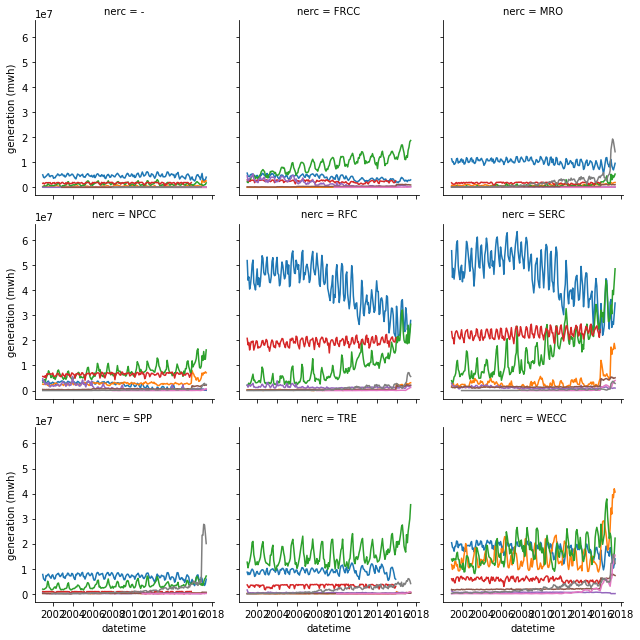

In [94]:
g = sns.FacetGrid(final, col='nerc', col_wrap=3, hue='fuel category')
g.map(plt.plot, 'datetime', 'generation (mwh)')

In [102]:
total_monthly_gen = final.groupby(['year', 'nerc', 'month'])['generation (mwh)'].sum()

In [103]:
total_monthly_gen.head()

year  nerc  month
2001  -     1        7185661.388
            2        6526739.453
            3        6304139.884
            4        6624660.323
            5        7045482.729
Name: generation (mwh), dtype: float64

## CO₂ emissions intensity by NERC region

In [98]:
co2_nerc.head()

year  nerc  month
2001  -     1        5.476076e+09
            2        4.349473e+09
            3        4.223575e+09
            4        4.544873e+09
            5        4.972656e+09
Name: final co2 (kg), dtype: float64

In [104]:
type(co2_nerc), type(total_monthly_gen)

(pandas.core.series.Series, pandas.core.series.Series)

In [ ]:
co2_nerc.n

In [110]:
nerc_index = co2_nerc.sort_index() / total_monthly_gen.sort_index()
nerc_index.name = 'index'
nerc_index = nerc_index.reset_index()
add_datetime(nerc_index)

In [111]:
nerc_index.tail()

,year,nerc,month,index,datetime
1777,2017,WECC,2,205.111206,2017-02-01
1778,2017,WECC,3,159.526334,2017-03-01
1779,2017,WECC,4,142.802089,2017-04-01
1780,2017,WECC,5,155.643177,2017-05-01
1781,2017,WECC,6,179.053433,2017-06-01


And it looks like something is wrong with the generation or emissions data :(

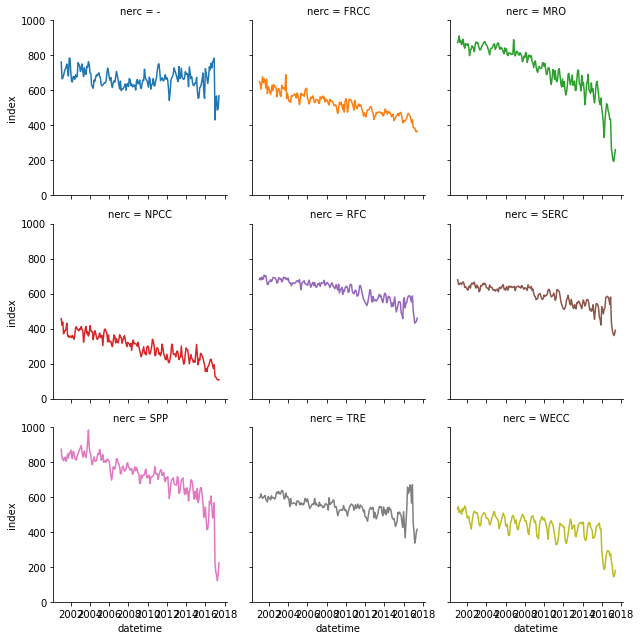

In [113]:
g = sns.FacetGrid(nerc_index, col='nerc', col_wrap=3, hue='nerc')
g.map(plt.plot, 'datetime', 'index')
g.set(ylim=(0, 1000))